## Evaluation of generated candidates


Global picture:

<img height=400 width=700 src="Wild-Evaluation.png">


### Generative reranking

In the last meeting I said one thing wrong: Gen-Rank in the figure is a reranking with the generative model $p("c<sep>x"|x)$, after generating with it the list of candidates (beam search to maximize $p("c<sep>"|x)$. So, I evaluated how much the reranking (both with generative and discriminative systems) improves the performance:

| Ranking System | MAP | R@10 | MRR |
| --- |  --- | --- | --- |
| No reranking | 34.48 | 58.90 | 44.41 | 
| Generative reranking | **54.79** | **87.90**  | **63.93** |
| Discriminative reranking | 49.97 | 85.45 | 57.98 |
| Random reranking | 18.68 | 42.19 | 21.58 |

It seems that the discriminative model is good for distinguishing easy negative candidates (high performance in oracle rankings with randomly sampled negatives) but it is not as so good distinguishing hard negatives (generated by the generative model). So, I think it is very interesting to use the trained generative system to generate hard-negative candidates for training the discriminative model, and then see how it performs for reranking in the wild. That remembers me to ELECTRA: https://openreview.net/pdf?id=r1xMH1BtvB

### Precision @K


| Ranking System | P@1 | P@2 | P@3 | P@4 | P@5 | P@6 | P@7 | P@8 | P@9 | P@10 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| No reranking | 27.95 | 23.46 | 21.80 | 18.65 | 16.10 | 14.53 | 13.52 | 12.40 | 11.71 | 11.01 |
| Generative reranking | **46.41** | **40.90** | **33.42** | **29.68** | **25.85** | **23.38** | **21.21** | **19.42** | **17.84** | **16.51** |
| Discriminative reranking | 39.74 | 35.13 | 30.09 | 26.47 | 24.46 | 22.18 | 20.33 | 18.65 | 17.27 | 15.97 |
| Random reranking | 8.81 | 8.16 | 8.55 | 8.03 | 7.88 | 7.90 | 7.96 | 8.10 | 8.55 | 7.82 |


### Perplexity


I computed the perplexity of the generative approach in the wild, following the same methodology, but instead of computing ranking metrics, I have computed the average perplexity on the matched aggregations (exact matches between generated candidates and gold aggregations).

Fairseq returns the normalized probability of a sequence, $p(c|x)^{\frac{1}{N}} = e^{\frac{1}{N}\sum_{i=1}^{N}log(p(c_i | c_1^{i-1}, x))}$ and the perplexity can be seen as $PP(c|x) = \frac{1}{p(c|x)^\frac{1}{N}}$

| System | Perplexity |
| --- | --- |
| Generative (w/o reranking) | 42.47 |
| Generative (w/ reranking) |  |


I’m not sure about this evaluation, because, for example, for the generative reranking $p("c<sep>x”|x)$ is computed, while for generating the list of candidates $p(“c<sep>”|x)$ is computed. This will make the perplexity w/ the reranking much smaller than w/o the reranking, as $x$ is considered in the target and the probability for its tokens is pretty high, even when they may be similar in terms of the ranking evaluation. Also it could be difficult to compare different systems with different tokenizations, etc.

##### Code

In [1]:
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
import pickle as pkl
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import torch

%matplotlib notebook

In [93]:
with open("./error_analysis_json/generative_cf-v0_tf-v2_last.pkl", "rb") as fr:
    dict_outputs_generative = pkl.load(fr)

In [88]:
def get_ranks(outputs):
    """
    Returns the ranks according to the outputs (1 for highest grade). Deal with draws by assigning the best rank to the
    first output encountered.

    Args:
        outputs: torch.Tensor, (batch_size, 1 ou 2) tensors outputs.

    Returns:
        torch.Tensor, ranks corresponding to the grades in a line Tensor.
    """

    grades = outputs[:, -1]

    n = len(grades)

    sorter = torch.argsort(grades, descending=True)
    ranks = torch.zeros(n, dtype=torch.long)

    ranks[sorter] = torch.arange(1, n + 1)

    return ranks

def precision_at_k(ranks, targets, k):
    if targets.sum() == 0:
        return None

    else:
        mask = ranks <= k
        targets = targets[mask]

        mask = targets > 0
        targets[mask] = 1

        return torch.div(targets.sum().type(torch.float), k)
    
def recall_at_k(ranks, targets, k):
    n = targets.sum()
    if n == 0:
        return None

    else:
        mask = ranks <= k
        targets = targets[mask]

        return torch.div(targets.sum().type(torch.float), n)

def reciprocal_best_rank(ranks, targets):
    if targets.sum() == 0:
        return None

    else:
        mask = targets > 0
        ranks = ranks[mask]

        return ranks.min().type(torch.float).reciprocal()
    
def average_precision(ranks, targets):
    mask = targets > 0
    ranks = ranks[mask]
    n = len(ranks)

    if n == 0:
        return None

    else:
        ranks1 = ranks.expand((n, n))
        ranks2 = ranks.reshape((-1, 1)).expand((n, n))

        return torch.div(torch.ge(ranks2, ranks1).sum(dim=1).type(torch.float), ranks.type(torch.float)).mean()

In [89]:
def get_targets(generations, gold_aggregations):
    targets = np.zeros(len(generations), dtype="int32")
    for agg in gold_aggregations:
        pos_trg = get_position_match(agg, generations)
        if pos_trg is not None:
            targets[pos_trg] = 1
        
    return torch.tensor(targets)

def get_rankings(dict_outputs):
    loader = "test"
    seen_keys = ["seen", "unseen"]
    entity_types = ["person", "location", "org"]
    ranking_tasks = []
    for seen_key in seen_keys:
        for entity_type in entity_types:
            for instance in dict_outputs[loader][seen_key][entity_type]:
                ranking_tasks.append({"entities": instance["entities"],
                                      "choices": instance["choices"],
                                      "targets": instance["targets"],
                                      "generations": instance["generations"],
                                      "scores": instance["scores"],
                                      "preds": instance["preds"]})
    return ranking_tasks

def get_position_match(aggregation, generations):
    # Exact matching
    for i, gen in enumerate(generations):
        if aggregation == gen:
            return i
    return None

/home/jogonba2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Scores:
{'P@1': tensor(0.0846), 'R@1': tensor(0.0439), 'MAP': tensor(0.1864), 'MRR': tensor(0.2246), 'counts': 1.0}
{'P@2': tensor(0.0744), 'R@2': tensor(0.0791), 'MAP': tensor(0.1803), 'MRR': tensor(0.2174), 'counts': 1.0}
{'P@3': tensor(0.0821), 'R@3': tensor(0.1306), 'MAP': tensor(0.1899), 'MRR': tensor(0.2276), 'counts': 1.0}
{'P@4': tensor(0.0705), 'R@4': tensor(0.1425), 'MAP': tensor(0.1812), 'MRR': tensor(0.2222), 'counts': 1.0}
{'P@5': tensor(0.0795), 'R@5': tensor(0.2106), 'MAP': tensor(0.1816), 'MRR': tensor(0.2221), 'counts': 1.0}
{'P@6': tensor(0.0756), 'R@6': tensor(0.2435), 'MAP': tensor(0.1831), 'MRR': tensor(0.2138), 'counts': 1.0}
{'P@7': tensor(0.0868), 'R@7': tensor(0.3311), 'MAP': tensor(0.2103), 'MRR': tensor(0.2463), 'counts': 1.0}
{'P@8': tensor(0.0814), 'R@8': tensor(0.3501), 'MAP': tensor(0.1882), 'MRR': tensor(0.2242), 'counts': 1.0}
{'P@9': tensor(0.0829), 'R@9': tensor(0.3890), 'MAP': tensor(0.1957), 'MRR': tensor(0.2322), 'counts': 1.0}
{'P@10': tensor(0.07

<IPython.core.display.Javascript object>


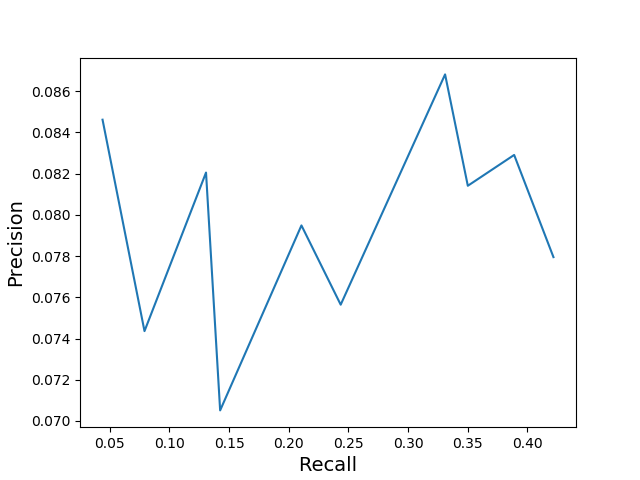

In [106]:
def evaluate_generations(dict_outputs, k, random_ranking=True):
    ranking_tasks = get_rankings(dict_outputs)
    
    metrics = {"P@%d"%k: 0, "R@%d"%k: 0, "MAP":0, "MRR":0, "counts": 0}
    #sum_matches = 0
    
    for ranking_task in ranking_tasks:                                       
        # Get the gold aggregations from the ranking_task
        choices = ranking_task["choices"]
        golds = ranking_task["targets"]
        aggregations = np.array(choices)[np.where(golds)].tolist()
        
        # Get the generations
        generations, scores = zip(*ranking_task["generations"])
        generations = [k.replace("|", "").strip() for k in generations]
        
        # Random ranking (shuffle the scores) #
        if random_ranking:
            scores = torch.tensor(scores).view(-1, 1)
            scores = scores[torch.randperm(scores.shape[0])]
        ######################################
        
        # Get the target of the generations (exact match)
        targets = get_targets(generations, aggregations)
        ranks = get_ranks(torch.tensor(scores).view(-1, 1))
        

        #sum_matches += sum(targets)
        
        pr = precision_at_k(ranks, targets, k)
        rc = recall_at_k(ranks, targets, k)
        ap = average_precision(ranks, targets)
        rr = reciprocal_best_rank(ranks, targets)
        
        if pr is not None:
            metrics["P@%d"%k] += pr 
            metrics["R@%d"%k] += rc
            metrics["MAP"] += ap
            metrics["MRR"] += rr
            metrics["counts"] += 1
    
        #print(generations)
        #print(aggregations)
        #print(targets)
        #print(ranks)

    for key in metrics:
        metrics[key] = metrics[key] / metrics["counts"]
                          
    return metrics

# Compute precision and recall curves until k=10 and plot them
max_k = 10
res = [evaluate_generations(dict_outputs_generative, k) for k in range(1, max_k+1)]

print("Scores:")
for out in res:
    print(out)
    
    
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.plot([res[i-1]["R@%d" % i].item() for i in range(1, len(res)+1)],
         [res[i-1]["P@%d" % i].item() for i in range(1, len(res)+1)])

In [99]:
with open("./error_analysis_json/generative_cf-v0_tf-v2_last.pkl", "rb") as fr:
    dict_outputs_generative = pkl.load(fr)

In [97]:
with open("./error_analysis_json/generative_paper.pkl", "rb") as fr:
    dict_outputs_generative = pkl.load(fr)

In [105]:
def perplexity(normalized_prob):
    return 1. / normalized_prob

def wild_eval_perplexity(dict_outputs):
    ranking_tasks = get_rankings(dict_outputs)
    ppl = 0
    norm = 0
    c = 0
    ppl = []
    for ranking_task in ranking_tasks:                                       
        # Get the gold aggregations from the ranking_task
        choices = ranking_task["choices"]
        golds = ranking_task["targets"]
        aggregations = np.array(choices)[np.where(golds)].tolist()

        # Get the generations
        generations, scores = zip(*ranking_task["generations"])
        generations = [k.replace("|", "").strip() for k in generations]

        # Get the target of the generations (exact match)
        targets = get_targets(generations, aggregations)
        scores = torch.tensor(scores)
       
        gold_scores = scores[targets > 0]
        print(ranking_task["entities"])
        print(aggregations)
        print(generations)
        print(targets)
        print(scores)
        print("-"*50 + "\n"*2)
        #print(gold_scores)
        #input()
        if len(gold_scores) > 0:
            ppl += perplexity(gold_scores).tolist()
            #aux_ppl = perplexity(gold_scores)
            #ppl += aux_ppl.sum()
            #norm += len(aux_ppl)
            #c += 1
    print(len(ppl))
    return torch.tensor(ppl).mean()#ppl / norm

wild_eval_perplexity(dict_outputs_generative)

['Aleksandr V. Donskoi', 'Dmitri A. Medvedev', 'Sergei B. Ivanov', 'Vladimir V. Putin']
['russians']
['russian politicians', 'russians', 'russian officials', 'politicians', 'russia politicians', 'russian men', 'russian politician', 'russian leaders', 'american politicians', 'republicans', 'russia officials', 'russian official', 'russian citizens', 'russian politics', 'political figures', 'political powers', 'politicans', 'government officials', 'politician', 'political players', 'Russian politicians', 'political leaders', 'Russian politicians', 'leaders']
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
tensor([0.0614, 0.0554, 0.0432, 0.0375, 0.0299, 0.0295, 0.0284, 0.0275, 0.0271,
        0.0267, 0.0259, 0.0257, 0.0255, 0.0247, 0.0238, 0.0138, 0.0133, 0.0127,
        0.0125, 0.0123, 0.0118, 0.0109, 0.0108, 0.0025])
--------------------------------------------------


['Bill Clinton', 'Joseph I. Lieberman', 'Ned Lamont']
['polit

tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
tensor([0.0709, 0.0669, 0.0660, 0.0660, 0.0619, 0.0614, 0.0470, 0.0432, 0.0425,
        0.0424, 0.0423, 0.0372, 0.0351, 0.0307, 0.0307, 0.0305, 0.0294, 0.0274,
        0.0234, 0.0162, 0.0147, 0.0147, 0.0141, 0.0029])
--------------------------------------------------


['Iraq', 'Russia']
['political powers', 'countries']
['western asian countries', 'western asia countries', 'middle eastern countries', 'east asian countries', 'north asian countries', 'european countries', 'asian countries', 'west asian countries', 'south asian countries', 'north asia countries', 'neighbours', 'middle eastern nations', 'middle east countries', 'asian nations', 'nations', 'asia countries', 'countries', 'american countries', 'middle eastern powers', 'political powers', 'world powers', 'regions', 'world countries', 'areas']
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]

tensor(42.4651)